## ДЗ 2 "Распознавание рукописных цифр"

ФИО: **Тренёв Иван Сергеевич**

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [173]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import torch
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.datasets import MNIST
from torchvision import transforms

from skimage.util import random_noise

import numpy as np
import sys
# from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1

In [174]:
class Linear:
    def __init__(self, input_size, output_size):
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''
        #### YOUR CODE HERE
        #### Create weights, initialize them with samples from N(0, 0.1).
        self.W = np.random.randn(input_size, output_size)*0.01
        self.b = np.zeros(output_size)

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, input_size).
        Returns output of size (N, output_size).
        Hint: You may need to store X for backward pass
        '''
        self.X = X
        return X.dot(self.W)+self.b

    def backward(self, dLdy):
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        self.dLdW = self.X.T.dot(dLdy)
        self.dLdb = dLdy.sum(0)
        self.dLdx = dLdy.dot(self.W.T)
        return self.dLdx

    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - learning_rate*dLdw
        '''
        self.W = self.W - learning_rate * self.dLdW
        self.b = self.b - learning_rate * self.dLdb

class Sigmoid:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.s = 1./(1+np.exp(-X))
        return self.s
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return self.s*(1-self.s)*dLdy
    
    def step(self, learning_rate):
        pass

class NLLLoss:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        pass
    
    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, C), where C is the number of classes
        y is np.array of size (N), contains correct labels
        '''
        self.p = np.exp(X)
        self.p /= self.p.sum(1, keepdims=True)
        self.y = np.zeros((X.shape[0], X.shape[1]))
        self.y[np.arange(X.shape[0]), y] =1
        return -(np.log(self.p)*self.y).sum(1).mean(0)
    
    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        return (self.p - self.y) / self.y.shape[0]


class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        self.modules = modules
    
    def forward(self, X):
        y = X
        for i in range(len(self.modules)):
            y = self.modules[i].forward(y)
        return y
    
    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        for i in range(len(self.modules))[::-1]:
            dLdy = self.modules[i].backward(dLdy)
    
    def step(self, learning_rate):
        for i in range(len(self.modules)):
            self.modules[i].step(learning_rate)


In [175]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

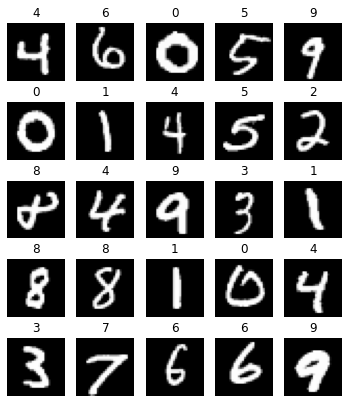

In [176]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [177]:
def train(network, epochs, learning_rate, train_loader,
          test_loader, plot=True, verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [178]:
def realization(activation, train_loader, test_loader, epochs = 20, learning_rate = 0.01):

  network = NeuralNetwork([
      Linear(784, 100), activation, # 28 * 28
      Linear(100, 100), activation,
      Linear(100, 10)
  ])
  loss = NLLLoss()

  tr, ts, tr_ac, ts_ac = train(network, epochs, learning_rate, train_loader, test_loader)

  return tr, ts, tr_ac, ts_ac

Epoch 19... (Train/Test) NLL: 0.483/0.459	Accuracy: 0.865/0.870

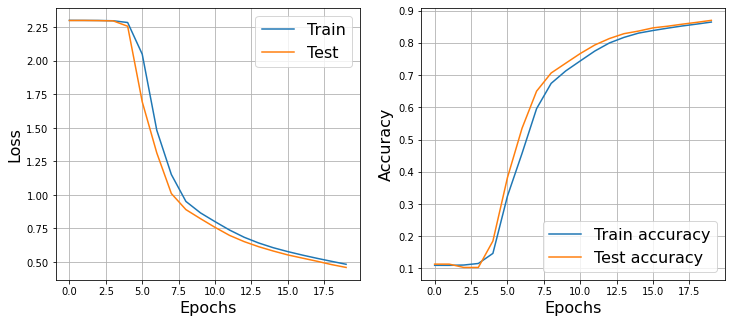

In [179]:
tr_s, ts_s, tr_ac_s, ts_ac_s = realization(Sigmoid(), train_loader, test_loader)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [ ]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [ ]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.048/0.080	Accuracy: 0.987/0.975

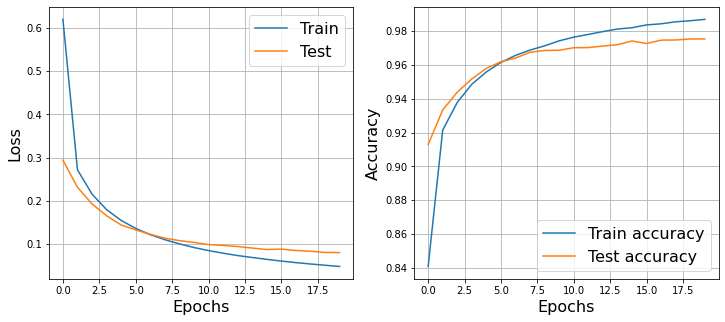

In [ ]:
tr_r, ts_r, tr_ac_r, ts_ac_r = realization(ReLU(), train_loader, test_loader)

Epoch 19... (Train/Test) NLL: 0.054/0.079	Accuracy: 0.985/0.976

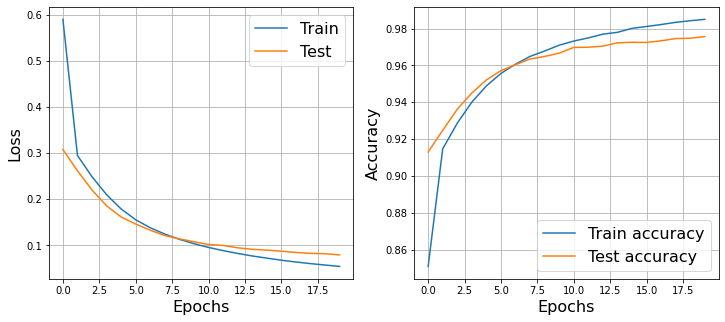

In [ ]:
tr_e, ts_e, tr_ac_e, ts_ac_e = realization(ELU(), train_loader, test_loader)

### HW1 (1 балл): Реализовать Tanh

In [ ]:
class Tanh:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.s = 2./(1+np.exp(-2*X)) - 1
        return self.s
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (1 - self.s**2)*dLdy
    
    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.062/0.090	Accuracy: 0.985/0.974

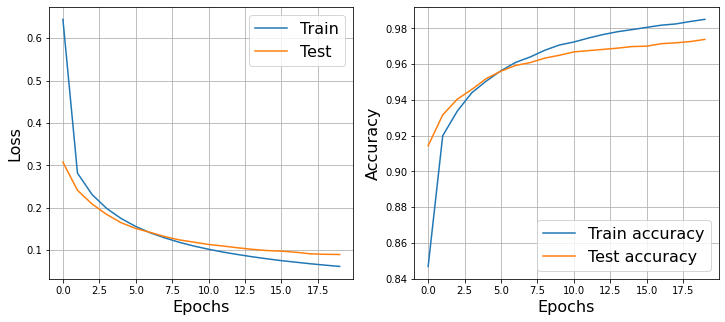

In [ ]:
tr_t, ts_t, tr_ac_t, ts_ac_t = realization(Tanh(), train_loader, test_loader)

### Часть 3: Анализ ошибок
На каких объектах сеть ошибается больше всего?

In [185]:
network = NeuralNetwork([
    Linear(784, 100), Tanh(), # 28 * 28
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])

wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = np.exp(network.forward(X))
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

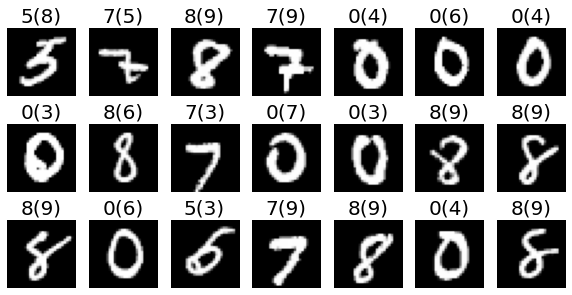

In [186]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(f"{correct_y[order[i]]}({predicted_y[order[i]]})", fontsize=20)
    plt.axis('off')

**8 - проблемный момент**

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [92]:
# Аугментация: гаусовский шум или "соль и перец"
class Noise(object):
    def __init__(self, mean = 0., std = 0.1, amount=0.05):
      self.amount = amount
      self.std = std
      self.mean = mean
        
    def __call__(self, tensor):
      return torch.tensor(random_noise(tensor, mode='gaussian', mean = self.mean, var = self.std))
      # return torch.tensor(random_noise(tensor, mode='salt', amount=self.amount))
    
    def __repr__(self):
      return self.__class__.__name__ + '(amount={0})'.format(self.amount)

In [124]:
transform_augmentation = transforms.Compose([
                       transforms.RandomRotation(degrees = 15), # вращения
                       transforms.RandomAffine(degrees = 0, translate = (0.1, 0.1)), # сдвиги
                       transforms.ToTensor(),
                       Noise(0., 0.01), # шум
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset_augmentation = MNIST('.', train=True, download=True, transform=transform_augmentation)

train_loader_augmentation = DataLoader(train_dataset_augmentation, batch_size=32, shuffle=True)

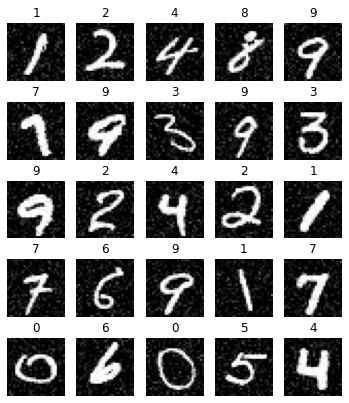

In [138]:
X, y = next(iter(train_loader_augmentation))
X = X.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

Epoch 19... (Train/Test) NLL: 0.356/0.198	Accuracy: 0.901/0.950

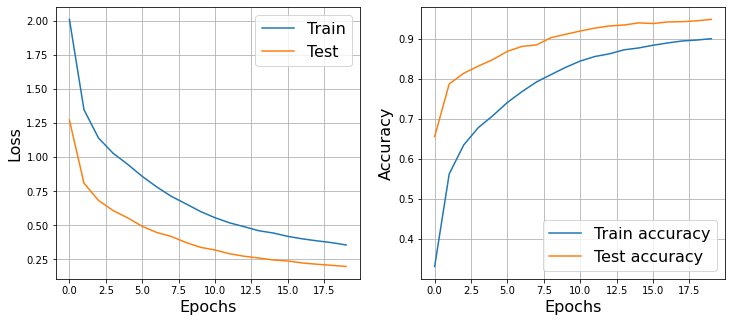

In [ ]:
tr_s_aug, ts_s_aug, tr_ac_s_aug, ts_ac_s_aug = realization(Sigmoid(), train_loader_augmentation, test_loader)

Epoch 19... (Train/Test) NLL: 0.169/0.085	Accuracy: 0.949/0.974

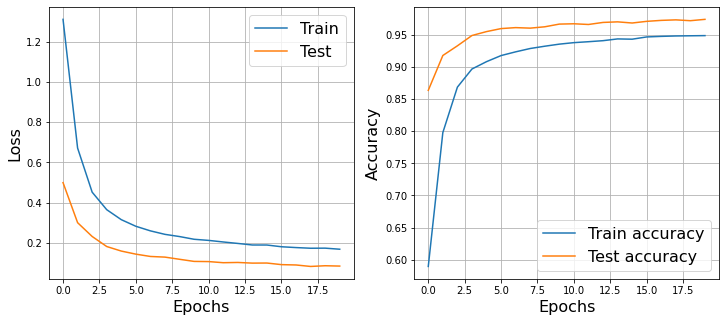

In [83]:
tr_r_aug, ts_r_aug, tr_ac_r_aug, ts_ac_r_aug = realization(ReLU(), train_loader_augmentation, test_loader)

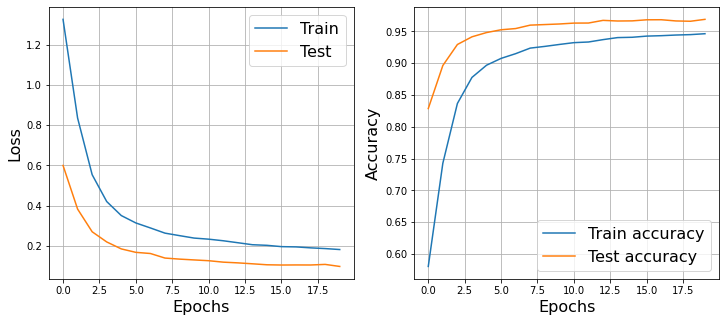

In [ ]:
tr_e_aug, ts_e_aug, tr_ac_e_aug, ts_ac_e_aug = realization(ELU(), train_loader_augmentation, test_loader)

Epoch 19... (Train/Test) NLL: 0.187/0.090	Accuracy: 0.945/0.974

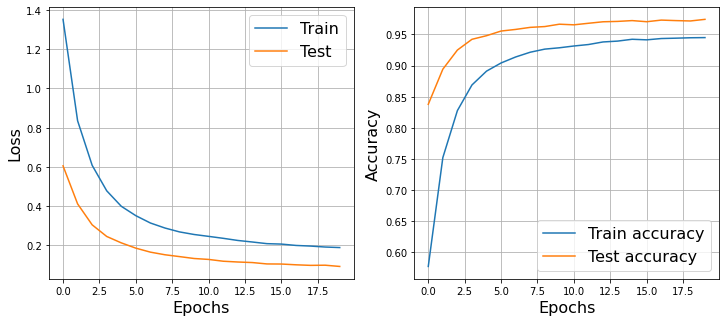

In [84]:
tr_t_aug, ts_t_aug, tr_ac_t_aug, ts_ac_t_aug = realization(Tanh(), train_loader_augmentation, test_loader)

In [137]:
# Тут выбираем какую-то одну аугментацию
transform_augmentation = transforms.Compose([
                      #  transforms.RandomRotation(degrees = 15), # вращения
                      #  transforms.RandomAffine(degrees = 0, translate = (0.1, 0.1)), # сдвиги
                       transforms.ToTensor(),
                       Noise(0., 0.01), # шум 
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset_augmentation = MNIST('.', train=True, download=True, transform=transform_augmentation)

train_loader_augmentation = DataLoader(train_dataset_augmentation, batch_size=32, shuffle=True)

Epoch 19... (Train/Test) NLL: 0.137/0.087	Accuracy: 0.960/0.974

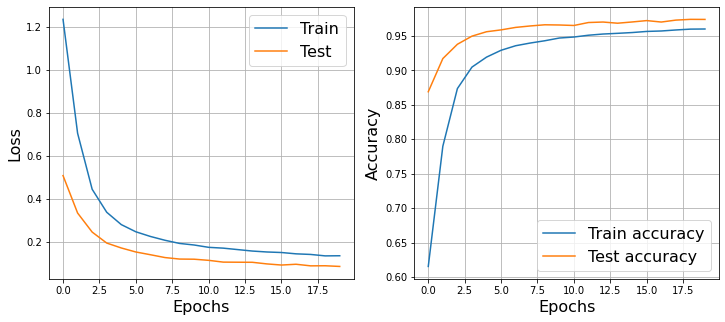

In [101]:
tr_e_aug_shift, ts_e_aug_shift, tr_ac_e_aug_shift, ts_ac_e_aug_shift = \
 realization(ELU(), train_loader_augmentation, test_loader)

Epoch 19... (Train/Test) NLL: 0.083/0.073	Accuracy: 0.975/0.977

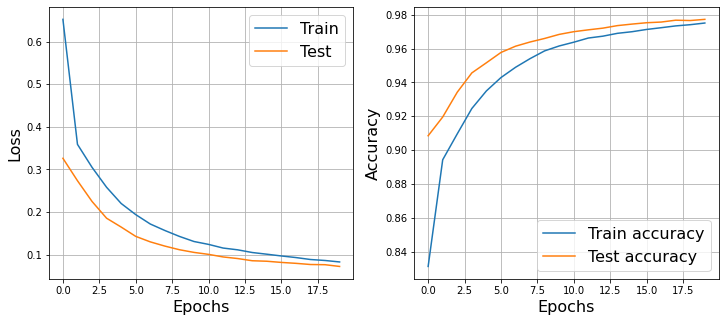

In [103]:
tr_e_aug_rot, ts_e_aug_rot, tr_ac_e_aug_rot, ts_ac_e_aug_rot = \
 realization(ELU(), train_loader_augmentation, test_loader)

Epoch 19... (Train/Test) NLL: 0.064/0.087	Accuracy: 0.981/0.974

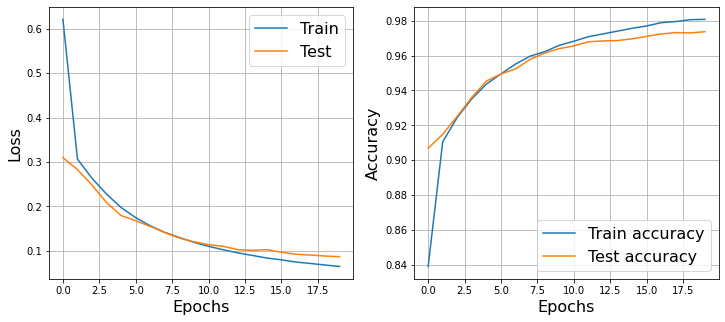

In [139]:
tr_e_aug_noise, ts_e_aug_noise, tr_ac_e_aug_noise, ts_ac_e_aug_noise = \
 realization(ELU(), train_loader_augmentation, test_loader)

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

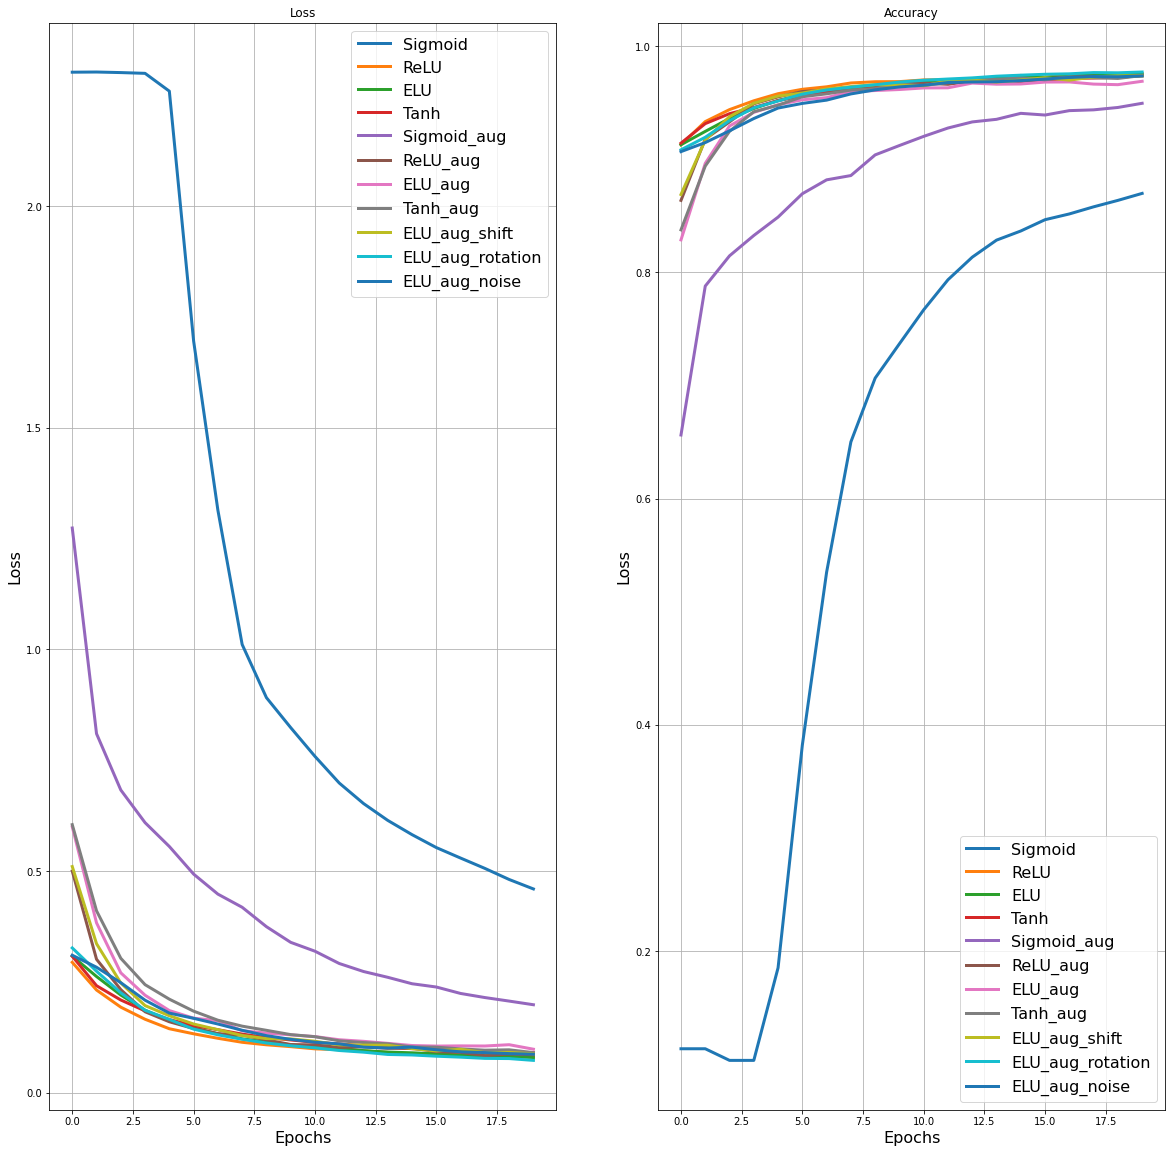

In [183]:
ts = (ts_s, ts_r, ts_e, ts_t, 
      ts_s_aug, ts_r_aug, ts_e_aug, ts_t_aug,
      ts_e_aug_shift, ts_e_aug_rot, ts_e_aug_noise)
ts_ac = (ts_ac_s, ts_ac_r, ts_ac_e, ts_ac_t,
         ts_ac_s_aug, ts_ac_r_aug, ts_ac_e_aug, ts_ac_t_aug,
         ts_ac_e_aug_shift, ts_ac_e_aug_rot, ts_ac_e_aug_noise)
labels = ('Sigmoid', 'ReLU', 'ELU', 'Tanh',
          'Sigmoid_aug', 'ReLU_aug', 'ELU_aug', 'Tanh_aug',
          'ELU_aug_shift', 'ELU_aug_rotation', 'ELU_aug_noise')

plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.title('Loss')
for i in range(len(labels)):
  plt.plot(ts[i], label=labels[i], linewidth=3)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
for i in range(len(labels)):
  plt.plot(ts_ac[i], label=labels[i], linewidth=3)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

Исходя из графиков ошибок и точности классификации, можно заключить:

*   результаты при аугментации оказались численно хуже (совсем не критично);
*   аугментация позволила избавиться от переобучения;
*   наилучший результат показала предобработка с добавлением небольших вращений;
*   лучше не использовать в качестве функции активации сигмоиду.



